In [ ]:
%pip install flaml[notebook]==1.0.10

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\17247\anaconda3\python.exe -m pip install --upgrade pip' command.


In [ ]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=40536, data_dir='./')
print("Data type:", type(X_train), type(y_train))
print("The first 5 rows of X_train:")
print(X_train.head())
print("The first 5 rows of y_train:")
print(y_train.head())

load dataset from ./openml_ds40536.pkl
Dataset name: SpeedDating
X_train.shape: (6283, 120), y_train.shape: (6283,);
X_test.shape: (2095, 120), y_test.shape: (2095,)
Data type: <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
The first 5 rows of X_train:
     has_null  wave  gender   age  age_o  d_age d_d_age  \
5546        1  14.0    male  25.0   32.0    7.0  [7-37]   
235         0   2.0  female  21.0   24.0    3.0   [2-3]   
7066        1  19.0  female  26.0   29.0    3.0   [2-3]   
7357        1  20.0  female  25.0   27.0    2.0   [2-3]   
1108        0   4.0  female  28.0   27.0    1.0   [0-1]   

                                       race  \
5546            European/Caucasian-American   
235   Asian/Pacific Islander/Asian-American   
7066            European/Caucasian-American   
7357                 Black/African American   
1108            European/Caucasian-American   

                                     race_o samerace  ...  \
5546            Europ

In [ ]:
#X_train = X_train.drop(['', 'Age', 'Tm'], axis=1)   THIS CAN BE USED TO FIX XGBOOST ERROR MAYBE?
#X_train.info()

In [ ]:
from flaml import AutoML
automl = AutoML()

In [ ]:
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'accuracy',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 9458192,    # random seed
}

In [ ]:
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 10-15 21:32:56] {2540} INFO - task = classification
[flaml.automl: 10-15 21:32:56] {2542} INFO - Data split method: stratified
[flaml.automl: 10-15 21:32:56] {2545} INFO - Evaluation method: cv
[flaml.automl: 10-15 21:32:56] {2664} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 10-15 21:32:56] {2806} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-15 21:32:56] {3108} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-15 21:32:57] {3241} INFO - Estimated sufficient time budget=14550s. Estimated necessary time budget=357s.
[flaml.automl: 10-15 21:32:57] {3288} INFO -  at 1.8s,	estimator lgbm's best error=0.1623,	best estimator lgbm's best error=0.1623
[flaml.automl: 10-15 21:32:57] {3108} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-15 21:32:59] {3288} INFO -  at 3.3s,	estimator lgbm's best error=0.1550,	best estimator lgbm's best error=0.1550
[flaml.a

In [ ]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 383, 'num_leaves': 148, 'min_child_samples': 81, 'learning_rate': 0.07349456601711642, 'log_max_bin': 9, 'colsample_bytree': 0.7945324135347446, 'reg_alpha': 0.0038090040724731134, 'reg_lambda': 0.0027820040646453358}
Best accuracy on validation data: 0.8743
Training duration of best run: 1.497 s


In [ ]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.7945324135347446,
               learning_rate=0.07349456601711642, max_bin=511,
               min_child_samples=81, n_estimators=383, num_leaves=148,
               reg_alpha=0.0038090040724731134,
               reg_lambda=0.0027820040646453358, verbose=-1)

In [ ]:
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels ['0' '0' '0' ... '0' '0' '0']
True labels 2265    0
2851    0
3655    0
196     0
3719    0
       ..
3791    0
7913    0
1790    0
5318    0
7318    0
Name: match, Length: 2095, dtype: category
Categories (2, object): ['0' < '1']


In [ ]:
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

accuracy = 0.8706443914081146
roc_auc = 0.8808645533141212
log_loss = 0.399702410433201


In [ ]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 6283, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 6283, 'Current Hyper-parameters': {'n_estimators': 5, 'num_leaves': 4, 'min_child_samples': 35, 'learning_rate': 0.217390709783794, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.10260733108888935}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 5, 'num_leaves': 4, 'min_child_samples': 35, 'learning_rate': 0.217390709783794, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.00

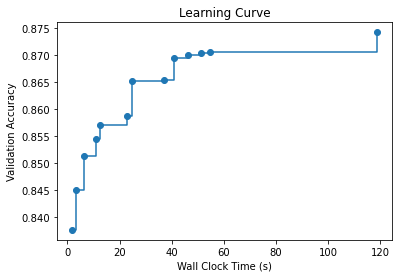

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

In [ ]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
y_pred_lgbm = lgbm.predict(X_test)

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
cat_columns = X_train.select_dtypes(include=['category']).columns
X = X_train.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)

In [ ]:
xgb.fit(X, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
X = X_test.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
y_pred_xgb = xgb.predict(X)
#label_encoded_y_test = label_encoder.transform(y_pred_xgb)
#y_pred_xgb = label_encoder.transform(y_pred_xgb)

In [ ]:
y_test = [int(x) for x in np.array(y_test)]
y_pred_lgbm = [int(x) for x in np.array(y_pred_lgbm)]
y_pred = [int(x) for x in np.array(y_pred)]
# print(np.array(y_pred_xgb))
# print(y_test)

In [ ]:
from catboost import CatBoostClassifier, Pool
cat = CatBoostClassifier()
X_train = X_train.apply(lambda x: x.fillna(x.value_counts().index[0]))
pool_train = Pool(X_train, y_train,
                 cat_features = ['samerace', 'has_null', 'gender', 'd_d_age', 'race', 'race_o', 'd_importance_same_race', 'd_importance_same_religion', 'field', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important', 'd_ambtition_important', 'd_shared_interests_important', 'd_attractive', 'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition', 'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner', 'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner', 'd_sports', 'd_tvsports', 'd_exercise', 'd_dining', 'd_museums', 'd_art', 'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv', 'd_theater', 'd_movies', 'd_concerts', 'd_music', 'd_shopping', 'd_yoga', 'd_interests_correlate', 'd_expected_happy_with_sd_people', 'd_expected_num_interested_in_me', 'd_expected_num_matches', 'd_like', 'd_guess_prob_liked'])
#pool_train = Pool(X_train, y_train,
                # cat_features = ['has_null, gender, d_d_age, race, race_o'])    

In [ ]:
X_test = X_test.apply(lambda x: x.fillna(x.value_counts().index[0]))
y_pred_cat = cat.predict(X_test)

In [ ]:
##X_train['has_null'] = X_train['has_null'].astype(str)
#X_train['gender'] = X_train['gender'].astype(str)
#X_train['race'] = X_train['race'].astype(str)
#X_train['race_o'] = X_train['race_o'].astype(str)

In [ ]:
cat.fit(pool_train)

Learning rate set to 0.022581
0:	learn: 0.6767318	total: 16.7ms	remaining: 16.7s
1:	learn: 0.6604394	total: 88.2ms	remaining: 44s
2:	learn: 0.6444996	total: 166ms	remaining: 55.3s
3:	learn: 0.6271804	total: 241ms	remaining: 59.9s
4:	learn: 0.6136201	total: 330ms	remaining: 1m 5s
5:	learn: 0.5979485	total: 392ms	remaining: 1m 4s
6:	learn: 0.5834228	total: 476ms	remaining: 1m 7s
7:	learn: 0.5710384	total: 559ms	remaining: 1m 9s
8:	learn: 0.5598423	total: 610ms	remaining: 1m 7s
9:	learn: 0.5491349	total: 693ms	remaining: 1m 8s
10:	learn: 0.5376392	total: 763ms	remaining: 1m 8s
11:	learn: 0.5281121	total: 848ms	remaining: 1m 9s
12:	learn: 0.5185099	total: 927ms	remaining: 1m 10s
13:	learn: 0.5110905	total: 988ms	remaining: 1m 9s
14:	learn: 0.5023732	total: 1.06s	remaining: 1m 9s
15:	learn: 0.4935596	total: 1.14s	remaining: 1m 10s
16:	learn: 0.4849720	total: 1.23s	remaining: 1m 11s
17:	learn: 0.4793515	total: 1.3s	remaining: 1m 11s
18:	learn: 0.4731174	total: 1.38s	remaining: 1m 11s
19:	lea

In [ ]:
print('default xgboost accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_xgb, y_test))
print('default lgbm accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_lgbm, y_test))
print('default catboost accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_cat, y_test))
print('flaml (10 min) accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))

default xgboost accuracy = 0.8692124105011934
default lgbm accuracy = 0.863961813842482
default catboost accuracy = 0.8663484486873508
flaml (5 min) accuracy = 0.8706443914081146
r2 = 0.09102625680435461
mse = 0.12935560859188544
mae = 0.12935560859188544


In [ ]:
predict = automl.predict(X_test)
predict = [int(x) for x in np.array(predict)]
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      1735
           1       0.71      0.42      0.53       360

    accuracy                           0.87      2095
   macro avg       0.80      0.69      0.73      2095
weighted avg       0.86      0.87      0.86      2095



In [ ]:
import pickle
with open('SpeedDate.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
#from sklearn.metrics import roc_curve, auc
#Xbin_train, Xbin_test, ybin_train, ybin_test = train_test_split(X, ybin, test_size=0.3)

#poly_clf2.fit(Xbin_train, ybin_train)
#ybin_test_pred = poly_clf2.decision_function(Xbin_test)
#fpr1, tpr1, te_thresholds1 = roc_curve(ybin_test, ybin_test_pred)

#xgb_clf2.fit(Xbin_train, ybin_train)
#ybin_test_pred2 = xgb_clf2.predict_proba(Xbin_test)[:,1]
#fpr2, tpr2, te_thresholds2 = roc_curve(ybin_test, ybin_test_pred2)

#log_reg1.fit(Xbin_train, ybin_train)
#ybin_test_pred3 = log_reg1.predict_proba(Xbin_test)[:,1]
#fpr3, tpr3, te_thresholds3 = roc_curve(ybin_test, ybin_test_pred3)

#plt.figure(figsize=(10,7))
#plt.grid()
#plt.plot(fpr1, tpr1, label='Poly_SVM')
#plt.plot(fpr2, tpr2, label='XGBoost_clf')
#plt.plot(fpr3, tpr3, label='Logistic_reg')
#plt.legend(loc='lower right')
#plt.plot([0,1],[0,1], 'k--')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.show()

In [ ]:
# %%
#import pandas as pd
#import numpy as np
#from sklearn.model_selection import train_test_split
#from flaml import AutoML
#from sklearn.metrics import accuracy_score
#from sklearn.datasets import load_boston
#from sklearn.metrics import max_error, mean_absolute_error, mean_squared_log_error, mean_squared_error, r2_score
# Classification with FLAML

In [ ]:
#x = dataset.data
#y = dataset.target
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)
#automl_clf = AutoML()
#automl_clf.fit(x_train, y_train, task="classification")